<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Pradan/MLLatest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# Install necessary libraries
try:
    import gdown
except ImportError:
    !pip install gdown

try:
    import tqdm
except ImportError:
    !pip install tqdm

import pandas as pd
import numpy as np
import string
import os.path
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import requests
import zipfile
from pathlib import Path
from sklearn.metrics import fbeta_score



In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
train_path= '/content/drive/MyDrive/Colab Notebooks/ML/Dataset/sartorius-cell-instance-segmentation/train'
csv_path='/content/drive/MyDrive/Colab Notebooks/ML/Dataset/sartorius-cell-instance-segmentation/train.csv'
#test_path= '/content/drive/"My Drive"/name_of_dataset_folder'
# os.chdir('/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation')

_, _, files = next(os.walk(train_path))
file_count = len(files)

annotations = pd.read_csv(csv_path)

height = annotations['height'][0]
width =  annotations['width'][0]

sample_ids = annotations['id'].unique()

print(len(sample_ids))
print(len(annotations))
print(file_count)
print(height)
print(width)

606
73585
606
520
704


In [21]:
from PIL import Image

def decode_rle(rle_string, height, width):
    rle_numbers = list(map(int, rle_string.split()))
    mask = np.zeros(height * width, dtype=np.uint8)

    for start, length in zip(rle_numbers[0::2], rle_numbers[1::2]):
        start -= 1  # Convert to zero-indexed
        mask[start:start + length] = 1

    return mask.reshape((height, width))

data_dict = {}

ids = []
masks = []

for id in sample_ids:
  id_df = annotations[annotations['id'] == id]
  id_annotations = id_df['annotation']
  all_masks = []
  for annot in id_annotations:
    mask = decode_rle(annot, height, width)
    all_masks.append(mask)
  resultant_mask = all_masks[0]

  for mask in all_masks[1:]:
    resultant_mask = np.bitwise_or(resultant_mask, mask)

  ids.append(id)
  masks.append(resultant_mask)

data_dict['id'] = ids
data_dict['annotation'] = masks

annotations = pd.DataFrame(data_dict)

print(annotations.head())
print(len(annotations))


             id                                         annotation
0  0030fd0e6378  [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
1  0140b3c8f445  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
2  01ae5a43a2ab  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  026b3c2c4b32  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  029e5b3b89c7  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
606


(520, 704)
(704, 520)


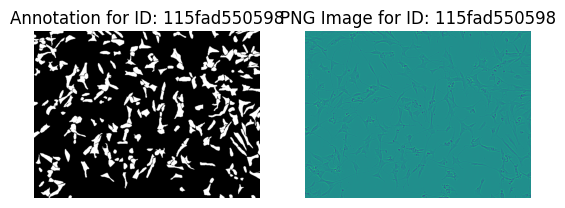

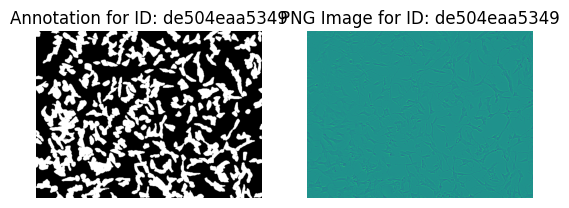

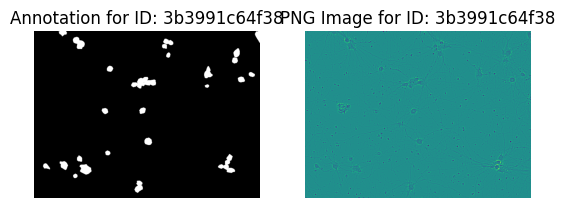

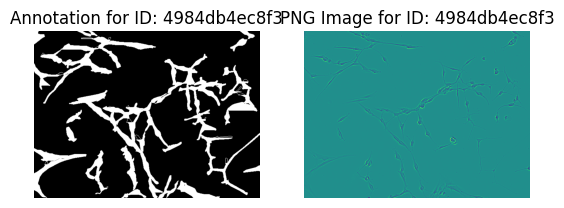

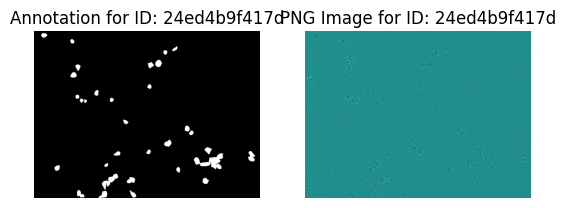

In [22]:
random_rows = annotations.sample(n=5)

print(annotations['annotation'][0].shape)
img = Image.open(train_path + '/' + annotations['id'][0] + '.png')
print(img.size)

# Iterate over the selected random rows
for index, row in random_rows.iterrows():
    plt.subplot(1, 2, 1)
    plt.imshow(row['annotation'], cmap='gray')
    plt.title('Annotation for ID: ' + row['id'])
    plt.axis('off')

    # Load and display the corresponding PNG image based on the ID
    plt.subplot(1, 2, 2)
    img = Image.open(train_path + '/' + row['id'] + '.png')
    plt.imshow(img)
    plt.title('PNG Image for ID: ' + row['id'])
    plt.axis('off')

    plt.show()

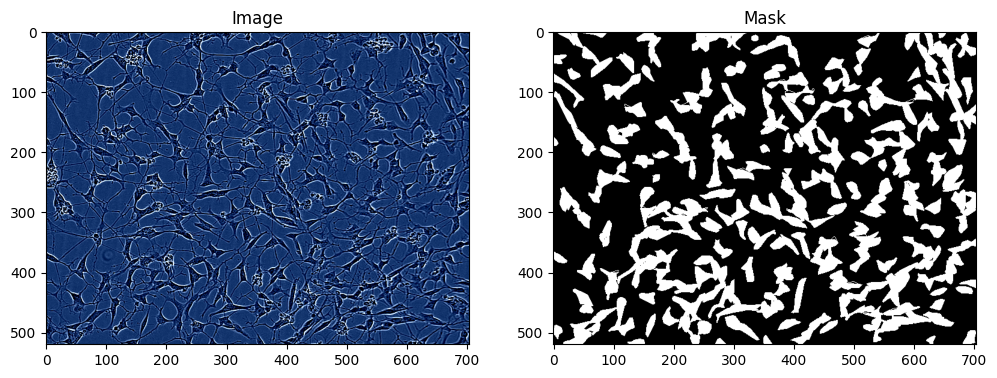

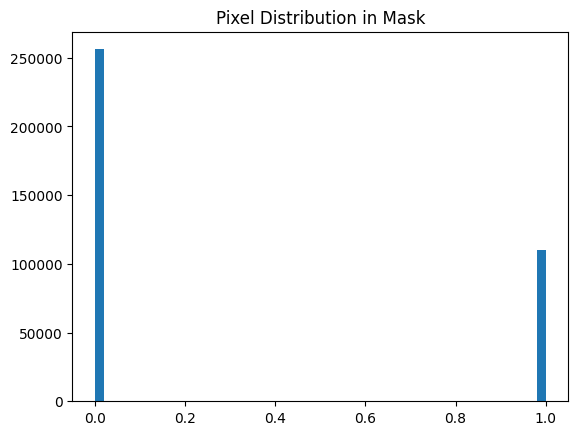

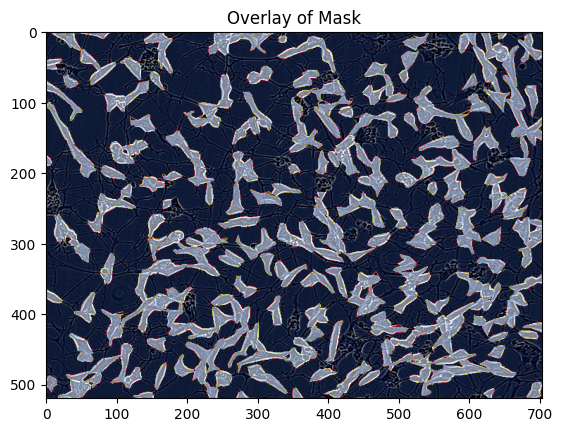

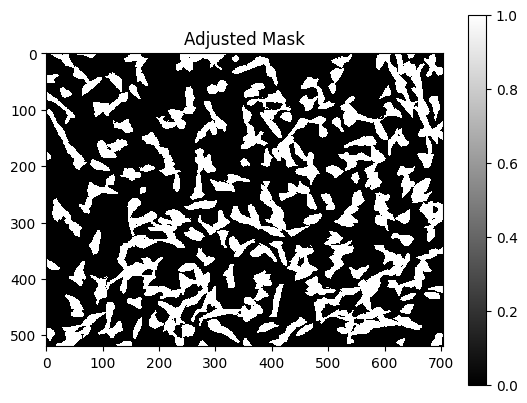

In [23]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os
from PIL import Image
from torchvision.transforms.functional import to_tensor, hflip, vflip

class RandomHorizontalVerticalFlip:
    """Apply horizontal or vertical flip randomly to both image and mask."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if torch.rand(1) < self.p:
            image = hflip(image)
            mask = hflip(mask)
        if torch.rand(1) < self.p:
            image = vflip(image)
            mask = vflip(mask)
        return image, mask

# Define the complete transformation for images and masks
def transform(image, mask):
    # Convert image and mask to tensors if they are not already
    if isinstance(image, Image.Image):
        image = to_tensor(image)
    if isinstance(mask, np.ndarray):
        mask = torch.from_numpy(mask).float()  # Convert to float for visualization

    transform = RandomHorizontalVerticalFlip(p=0.5)
    image, mask = transform(image, mask)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = normalize(image)

    return image, mask

class SartoriusDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations  # Assume annotations is already a DataFrame
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations['id'][idx]

        img_path = os.path.join(self.img_dir, f'{img_id}.png')
        image = Image.open(img_path).convert("RGB")

        mask = self.annotations['annotation'][idx]

        # Get bounding box coordinates for each mask
        pos = np.where(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)

        labels = torch.as_tensor([1], dtype=torch.int64)  # All cells are label 1

        masks = torch.as_tensor(mask, dtype=torch.uint8).unsqueeze(0)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, target

# Assuming 'annotations' is your DataFrame and 'train_path' is the directory where your images are stored
dataset = SartoriusDataset(annotations, train_path, transform=transform)

import matplotlib.pyplot as plt
import numpy as np

# Visualize a sample from the dataset
image, target = dataset[0]  # Get the first sample

# Assuming `image` is a PyTorch tensor with shape (3, height, width)
# Convert it to a numpy array and transpose it to (height, width, 3) for visualization
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # Rearrange dimensions
elif isinstance(image, np.ndarray):
    if image.ndim == 3 and image.shape[0] == 3:  # If it's in CHW format
        image = np.transpose(image, (1, 2, 0))  # Change to HWC for imshow

# Now use plt.imshow() to display the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

# Assuming `mask` is also a tensor and needs to be squeezed if it has a channel dimension
mask = target["masks"].squeeze().numpy()  # Remove channel dimension if it exists

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

plt.hist(mask.ravel(), bins=50, range=[0,1])
plt.title('Pixel Distribution in Mask')
plt.show()

plt.imshow(image)
plt.imshow(mask, cmap='hot', alpha=0.5)  # overlay mask
plt.title('Overlay of Mask')
plt.show()

plt.imshow(mask, cmap='gray', interpolation='none')
plt.colorbar()
plt.title('Adjusted Mask')
plt.show()


In [24]:
import torch
import torch.nn as nn
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
import multiprocessing as mp
import matplotlib.pyplot as plt

# Set the multiprocessing start method
mp.set_start_method('spawn', force=True)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define the number of classes (2 for background and cell)
num_classes = 2

# Load the pre-trained Mask R-CNN model
weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
model = maskrcnn_resnet50_fpn(weights=weights)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the box predictor with a new one for our number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256

# Replace the mask predictor with a new one for our number of classes
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

# Move the model to the appropriate device
model = model.to(DEVICE)

# Define the optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Define the gradient scaler for mixed precision training
scaler = GradScaler()

# Assuming 'dataset' is already defined and is an instance of a Dataset class
total_size = len(dataset)
val_size = int(0.1 * total_size)  # 10% for validation
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Total number of data samples: {total_size}")
print(f"Number of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")

def collate_fn(batch):
    return tuple(zip(*batch))

# Use a smaller batch size and more workers for data loading
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

# Check the number of batches in the DataLoader and the number of samples per batch
num_batches = len(train_loader)
print(f"Number of batches in the training DataLoader: {num_batches}")

# Function to check for NaNs in tensors
def check_for_nans(tensor, name):
    if torch.isnan(tensor).any():
        print(f"NaNs found in {name}")

# Function to visualize predictions
def visualize_predictions(images, targets, outputs):
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title('Original Image')

        # Ground truth mask
        true_mask = targets[i]['masks'].squeeze(0).cpu().numpy()
        ax[1].imshow(true_mask, cmap='gray')
        ax[1].set_title('Ground Truth Mask')

        # Predicted mask
        pred_mask = outputs[i]['masks'].squeeze(1).cpu().numpy()[0]
        ax[2].imshow(pred_mask, cmap='gray')
        ax[2].set_title('Predicted Mask')

        plt.show()

Total number of data samples: 606
Number of training samples: 546
Number of validation samples: 60
Number of batches in the training DataLoader: 273


In [25]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader):
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Use mixed precision training
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        check_for_nans(losses, "losses")

        if torch.isnan(losses).any():
            print(f"NaNs in losses at batch {batch_idx}")
            continue  # Skip this batch

        scaler.scale(losses).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Add gradient clipping
        scaler.step(optimizer)
        scaler.update()

        running_loss += losses.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Update the learning rate
    scheduler.step()

# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ML/mask_rcnn_model.pth')

Epoch 1/15, Loss: 0.4735
Epoch 2/15, Loss: 0.3520
Epoch 3/15, Loss: 0.3424
Epoch 4/15, Loss: 0.3313
Epoch 5/15, Loss: 0.3289
Epoch 6/15, Loss: 0.3240
Epoch 7/15, Loss: 0.3261
Epoch 8/15, Loss: 0.3238
Epoch 9/15, Loss: 0.3225
Epoch 10/15, Loss: 0.3211
Epoch 11/15, Loss: 0.3222
Epoch 12/15, Loss: 0.3234
Epoch 13/15, Loss: 0.3206
Epoch 14/15, Loss: 0.3210
Epoch 15/15, Loss: 0.3215


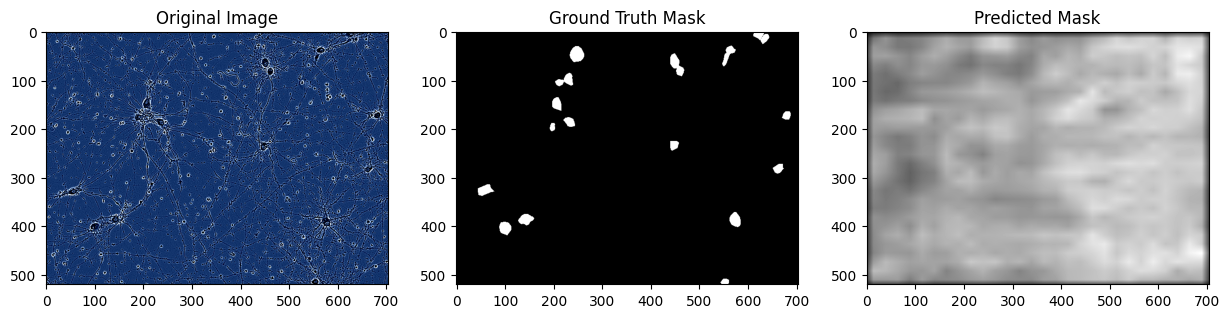

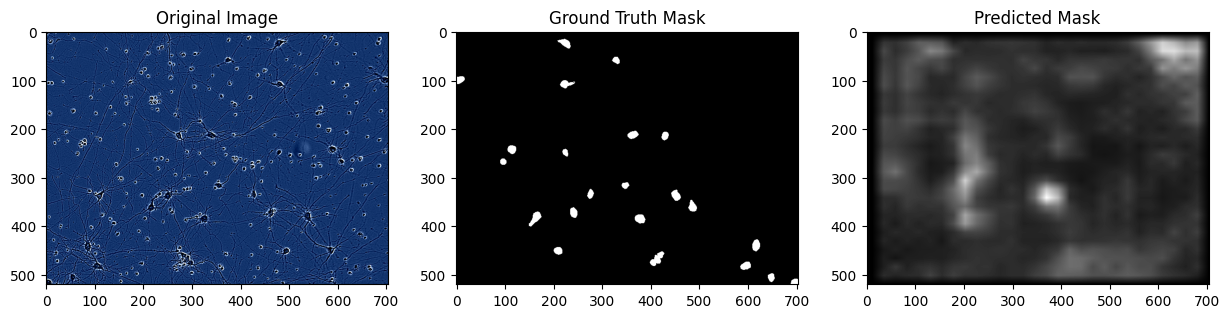

In [26]:
import matplotlib.pyplot as plt

# Visualize some predictions and their corresponding targets
def visualize_predictions(images, targets, outputs):
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        # Original image
        ax[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax[0].set_title('Original Image')

        # Ground truth mask
        true_mask = targets[i]['masks'].squeeze(0).cpu().numpy()
        ax[1].imshow(true_mask, cmap='gray')
        ax[1].set_title('Ground Truth Mask')

        # Predicted mask
        pred_mask = outputs[i]['masks'].squeeze(1).cpu().numpy()[0]
        ax[2].imshow(pred_mask, cmap='gray')
        ax[2].set_title('Predicted Mask')

        plt.show()

# Assuming 'images', 'targets', and 'outputs' are available
visualize_predictions(images, targets, outputs)


In [42]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Custom function to calculate loss during validation
def calculate_validation_loss(predictions, targets, criterion):
    total_loss = 0.0
    for pred, target in zip(predictions, targets):
        pred_masks = pred['masks'].squeeze(1)  # [num_instances, H, W]
        true_masks = target['masks']  # [1, H, W]
        true_masks = true_masks.expand_as(pred_masks)  # Expand to match dimensions

        loss = criterion(pred_masks, true_masks.float())
        total_loss += loss.item()
    return total_loss

# Define the criterion (loss function)
criterion = nn.BCEWithLogitsLoss()

# Validation loop
model.eval()  # Set the model to evaluation mode
val_loss = 0.0

# Create empty lists to store predicted masks and ground truth masks
predicted_masks = []
gt_masks = []
input_images = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, targets in val_loader:
        # Move data to the appropriate device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        # Forward pass to get predictions
        outputs = model(images)

        # Calculate loss manually using the custom function
        losses = calculate_validation_loss(outputs, targets, criterion)

        # Accumulate validation loss
        val_loss += losses

        # Process and store predictions and ground truth
        for i, output in enumerate(outputs):
            pred_mask = output['masks'].squeeze(1).cpu().detach().numpy() > 0.5  # Threshold predictions
            gt_mask = targets[i]['masks'].squeeze(0).cpu().detach().numpy()

            # Ensure gt_mask has the correct shape
            if gt_mask.ndim == 1:
                gt_mask = gt_mask.reshape(pred_mask.shape)

            predicted_masks.append(pred_mask)
            gt_masks.append(gt_mask)
            input_images.append(images[i].cpu().detach().numpy())

# Compute average validation loss
avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss}")


Validation Loss: 1.4624344567457834


In [ ]:
# visualize the results
for i in range(len(input_images)):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    print(f"input_images[{i}] shape: {input_images[i].shape}")
    print(f"gt_masks[{i}] shape: {gt_masks[i].shape}")
    print(f"predicted_masks[{i}] shape: {predicted_masks[i].shape}")

    # Handle possible dimension mismatches
    if input_images[i].ndim == 3 and input_images[i].shape[0] in {1, 3}:  # CHW format
        image_to_show = np.transpose(input_images[i], (1, 2, 0))
    else:
        image_to_show = input_images[i]  # Already in HWC format

    # Original image
    ax[0].imshow(image_to_show)  # Assuming the image is in CHW format
    ax[0].set_title('Original Image')

    # Ground truth mask
    ax[1].imshow(gt_masks[i], cmap='gray')
    ax[1].set_title('Ground Truth Mask')

    # Predicted mask
    ax[2].imshow(predicted_masks[i], cmap='gray')
    ax[2].set_title('Predicted Mask')

    plt.show()
